In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import imutils

In [2]:
layout = cv2.imread('./gt_layout/9.png')
image = cv2.imread('./images/9.png')


In [3]:
x = np.unique(layout)

In [4]:
print(x)

[1 2 4 5]


In [5]:
if len(x)==2:
    layout = np.where(layout==1,70,layout)
    layout = np.where(layout==2,120,layout)
elif len(x)==3:
    layout = np.where(layout==1,70,layout)
    layout = np.where(layout==2,120,layout)
    layout = np.where(layout==3,170,layout)
elif len(x)==4:
    layout = np.where(layout==1,70,layout)
    layout = np.where(layout==2,120,layout)
    layout = np.where(layout==3,170,layout)
    layout = np.where(layout==4,200,layout)
else:
    layout = np.where(layout==1,70,layout)
    layout = np.where(layout==2,120,layout)
    layout = np.where(layout==3,170,layout)
    layout = np.where(layout==4,200,layout)
    layout = np.where(layout==5,220,layout)

In [6]:
z = np.unique(layout)

In [7]:
print(z)

[  5  70 120 200]


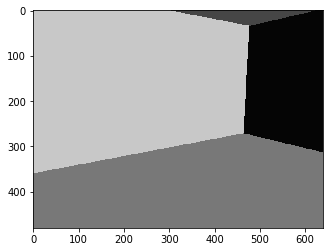

In [8]:
plt.imshow(layout)

In [9]:
faces = [i for i in z if i!=120 and i!=70]

In [10]:
faces

[5, 200]

In [11]:
def get_face(no_of_face,pixel,layout):
    face = layout.copy()
    non_blk_pixel = np.all(layout==[pixel,pixel,pixel],axis=-1)
    blk_pixel = np.any(layout!= [pixel,pixel,pixel],axis=-1)
    face[non_blk_pixel]=[255,255,255]
    face[blk_pixel]=[0,0,0]
    cv2.imwrite('face_'+str(no_of_face)+'.png',face)
    return face

In [12]:
#def find_contours(face,no_of_face):
 #   orig = face.copy()
  #  gray = cv2.cvtColor(orig,cv2.COLOR_BGR2GRAY)
   # _, contours,_ = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    #for cnt in contours:
     #   epsilon = 0.01 * cv2.arcLength(cnt,True)
      #  approx_1 = cv2.approxPolyDP(cnt,epsilon,True)
       # im = cv2.drawContours(orig,[approx_1],0,(0,255,0),3)
    #cv2.imwrite('contours_'+str(no_of_face)+'.png',orig)
    #return np.float32([approx_1[i][0] for i in range(len(approx_1))])
#cv2.imwrite('contours_layout_1.png',orig_1)
#print(approx_1)

In [ ]:
def find_contours(face,no_of_face):
    orig = face.copy()
    gray = cv2.cvtColor(orig,cv2.COLOR_BGR2GRAY)
    _, contours,_ = cv2.findContours(gray,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    
    
    
    for cnt in contours:
        epsilon = 0.01 * cv2.arcLength(cnt,True)
        approx_1 = cv2.approxPolyDP(cnt,epsilon,True)
        im = cv2.drawContours(orig,[approx_1],0,(0,255,0),3)
        
    cv2.imwrite('contours_'+str(no_of_face)+'.png',orig)
    return np.float32([approx_1[i][0] for i in range(len(approx_1))])
#cv2.imwrite('contours_layout_1.png',orig_1)
#print(approx_1)

In [13]:
def order_points(pts):
    # initialzie a list of coordinates that will be ordered
    # such that the first entry in the list is the top-left,
    # the second entry is the top-right, the third is the
    # bottom-right, and the fourth is the bottom-left
    rect = np.zeros((4, 2), dtype = "float32")
    # the top-left point will have the smallest sum, whereas
    # the bottom-right point will have the largest sum
    s = pts.sum(axis = 1)
    #print(s)
    rect[0] = pts[np.argmin(s)]
    #print(rect[0])
    rect[2] = pts[np.argmax(s)]
    #print(rect[2])
    # now, compute the difference between the points, the
    # top-right point will have the smallest difference,
    # whereas the bottom-left will have the largest difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    #print(rect[1])
    rect[3] = pts[np.argmax(diff)]
    #print(rect[3])
    # return the ordered coordinates
    return rect

def four_point_transform(image, pts):
	# obtain a consistent order of the points and unpack them
	# individually
	rect = order_points(pts)
	(tl, tr, br, bl) = rect
	# compute the width of the new image, which will be the
	# maximum distance between bottom-right and bottom-left
	# x-coordiates or the top-right and top-left x-coordinates
	widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
	widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
	maxWidth = max(int(widthA), int(widthB))
	# compute the height of the new image, which will be the
	# maximum distance between the top-right and bottom-right
	# y-coordinates or the top-left and bottom-left y-coordinates
	heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
	heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
	maxHeight = max(int(heightA), int(heightB))
	# now that we have the dimensions of the new image, construct
	# the set of destination points to obtain a "birds eye view",
	# (i.e. top-down view) of the image, again specifying points
	# in the top-left, top-right, bottom-right, and bottom-left
	# order
	dst = np.array([
		[0, 0],
		[maxWidth - 1, 0],
		[maxWidth - 1, maxHeight - 1],
		[0, maxHeight - 1]], dtype = "float32")
	# compute the perspective transform matrix and then apply it
	M = cv2.getPerspectiveTransform(rect, dst)
	warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
	# return the warped image
	return warped,M,maxWidth,maxHeight

In [14]:
binary_face = []
pts = []
width = []
height = []
for i in range(len(faces)):
     binary_face.append(get_face(i,faces[i],layout))
for j in range(len(faces)):
    pts.append(find_contours(binary_face[j],j))

In [15]:
image.shape[0]

480

In [16]:
for k in range(len(pts)):
    warped,M,w,h = four_point_transform(binary_face[k], pts[k])
    cv2.imwrite('warped_'+str(k)+'.png',warped)
    swatch = cv2.imread('100134753.png')
    crp = swatch[h:h+h,w:w+w]
    masked = cv2.bitwise_and(crp,warped)
    inv_warp = cv2.warpPerspective(warped,np.linalg.inv(M),(image.shape[1],image.shape[0]))
    inv_warp_m = cv2.warpPerspective(masked,np.linalg.inv(M),(image.shape[1],image.shape[0]))
    cv2.imwrite('inv_warp'+str(k)+'.png',inv_warp)
    cv2.imwrite('inn_warp_m'+str(k)+'.png',inv_warp_m)